# Index theory

First read some libraries needed. Notice, the functions we defined for plotting phase diagrams last time.


In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt 

%matplotlib inline

The routines from previous lectures.

In [2]:
def plot_flow(ax,rhs,xrange=[-2.5,2.5],yrange=[-2.5,2.5],xnum=100,ynum=100,nullclines=False):

    # Set up u,v space
    u = np.linspace(xrange[0], xrange[1], xnum)
    v = np.linspace(yrange[0], yrange[1], ynum)
    uu, vv = np.meshgrid(u, v)

# Compute derivatives
    u_vel = np.empty_like(uu)
    v_vel = np.empty_like(vv)
    for i in range(uu.shape[0]):
        for j in range(uu.shape[1]):
            u_vel[i,j], v_vel[i,j] = rhs(0,np.array([uu[i,j], vv[i,j]]))


# Make stream plot
    ax.streamplot(uu, vv, u_vel, v_vel,color='grey')
#Nullclines
    if nullclines: 
        ax.contour(uu, vv, u_vel, [0],colors=('r'))
        ax.contour(uu, vv, v_vel, [0],colors=('b'))

    return ax

# A function that plots a path 
# def plot_solution(ax,rhs,y0,t_end,t_dim=2000,color='green',init_pt=True,linewidth=2.5):

#     t = np.linspace(0, t_end, t_dim)
#     X = sc.integrate.solve_ivp(rhs,t_span=[t[0],t[-1]],y0=y0,t_eval=t)
#     x,y=X.y
#     t=X.t
#     ax.plot(x,y, color=color,linewidth=linewidth)
#     if (init_pt):
#         ax=plot_point(ax,y0,color=color)
#     return ax

def get_solution(rhs, y0, t_end, t_dim=2000):
    t = np.linspace(0, t_end, t_dim)
    sol = sc.integrate.solve_ivp(rhs, t_span=[t[0], t[-1]], y0=y0, t_eval=t)
    return sol

def plot_solution(ax, rhs, y0, t_end, t_dim=2000, color='green', init_pt=True, linewidth=2.5, linestyle='-'):
    sol = get_solution(rhs, y0, t_end, t_dim)
    x, y = sol.y
    ax.plot(x, y, color=color, linewidth=linewidth,linestyle=linestyle)
    if init_pt:
        ax = plot_point(ax, y0, color=color)
    return ax

def plot_point(ax, coord, color='black',markersize=20):
    """Add fixed points to plot."""
    x,y=coord
    ax.plot(x,y, '.', color='black', markerfacecolor=color, markersize=markersize)
    return ax


def jacobian(rhs, xy, eps=1e-8):
    """
    Compute the Jacobian matrix of a system of differential equations at a given point.
    Parameters:
    rhs (function): The right-hand side function of the differential equations. It should take two arguments: time (t) and state (xy).
    xy (array-like): The point (x, y) at which to evaluate the Jacobian.
    eps (float, optional): A small perturbation value for numerical differentiation. Default is 1e-8.
    Returns:
    numpy.ndarray: A 2x2 Jacobian matrix evaluated at the point (x, y).
    Note:
    This function uses finite differences to approximate the partial derivatives.

    WARNING: The code and comment are from Gemini, use at own risk. 
    """

    
    f0 = np.array(rhs(0, xy))
    jac = np.zeros((2, 2))
    
    for i in range(2):
        dxy = np.zeros(2)
        dxy[i] = eps
        f1 = np.array(rhs(0, xy + dxy))
        jac[:, i] = (f1 - f0) / eps
    
    return jac

def eigenvalues_eigenvectors(jac):
    """
    Calculate the eigenvalues and eigenvectors of a given Jacobian matrix.
    Parameters:
    jac (numpy.ndarray): A square matrix representing the Jacobian matrix.
    Returns:
    tuple: A tuple containing two elements:
        - eigenvalues (numpy.ndarray): An array of eigenvalues.
        - eigenvectors (numpy.ndarray): An array of eigenvectors, where each column is an eigenvector corresponding to the eigenvalue at the same index.


    WARNING: The code and comment are from Gemini, use at own risk. 
    """

    eigenvalues, eigenvectors = np.linalg.eig(jac)
    return eigenvalues, eigenvectors




## The example from last time
We will use
$$
\begin{array}{rl}
 x'(t) = & y \\[0.5pt]
 y'(t) = & x(1-x^2)-y
\end{array}
$$
as an example. Defining the function:

In [3]:
def rhs(t,xy):
    x,y=xy
    dx=y
    dy=x*(1-x**2)-y
    return [dx,dy]

## Jordan curves
 

### Definition of Jordan curves (Definition 8 on p 121)
A planar simple closed curve is called a *Jordan curve*.



In [4]:


def plot_jordan(ax,rhs,r0=[0,0],rr=1,num=25,vectors=True, color='blue',linewidth=1.5):
    theta=np.linspace(0,2*np.pi, num)
    x=rr*np.cos(theta)+r0[0]
    y=rr*np.sin(theta)+r0[1]
    ax.plot(x,y,linewidth=linewidth, color=color)
    if vectors:
        U,V=rhs(0,[x,y])
        ax.quiver(x,y,U,V)

    return ax





In [14]:
def winding_number(rhs, r0, rr, num=1000):
    theta = np.linspace(0, 2 * np.pi, num)
    x = rr * np.cos(theta) + r0[0]
    y = rr * np.sin(theta) + r0[1]
    
    F,G=rhs(0,[x,y])
    angles = np.arctan2(G, F)
    integrated_angle = np.sum(np.diff(np.unwrap(angles)))
    
    return integrated_angle / (2 * np.pi)

index = winding_number(rhs, r0, rr)
print(f"r0: {r0}, rr: {rr}")
print(f"The index of the Jordan curve is: {index}")

r0: [1, 0], rr: 0.5
The index of the Jordan curve is: 1.0


r0: [0, 0], rr: 0.5
The index of the Jordan curve is: -1.0


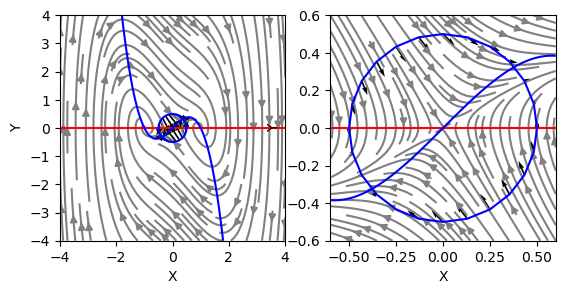

In [19]:
r0=[0,0]  # the coordinates for the centre of the circle
rr=  .5   # the radius of the circle

fig, ax = plt.subplots(1, 2)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_aspect('equal')

ax[0]=plot_flow(ax[0],rhs,xrange=[-4,4],yrange=[-4,4],nullclines=True)

# Lets plot a Jordan curve, a circle. 
ax[0]=plot_jordan(ax[0],rhs,r0=r0, rr=rr, vectors=True)


# A zoomed image
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_aspect('equal')
xrange=[r0[0]-rr-0.1,r0[0]+rr+0.1]
yrange=[r0[1]-rr-0.1,r0[1]+rr+0.1]
ax[1]=plot_flow(ax[1],rhs,xrange=xrange,yrange=yrange,nullclines=True)

# Lets plot a Jordan curve, a circle. 
ax[1]=plot_jordan(ax[1],rhs,r0=r0, rr=rr, vectors=True)

ax[1].set_xlim(xrange[0],xrange[1])
ax[1].set_ylim(yrange[0],yrange[1])

index = winding_number(rhs, r0, rr)
print(f"r0: {r0}, rr: {rr}")
print(f"The index of the Jordan curve is: {index}")

#ax=plot_jordan(ax,rhs,r0=r0, rr=1, vectors=True)

Play around with moving the circle to different locations and with different radius, bringing the different 

## The pendulum

r0: [3.141592653589793, 0], rr: 0.5
The index of the Jordan curve is: -1.0


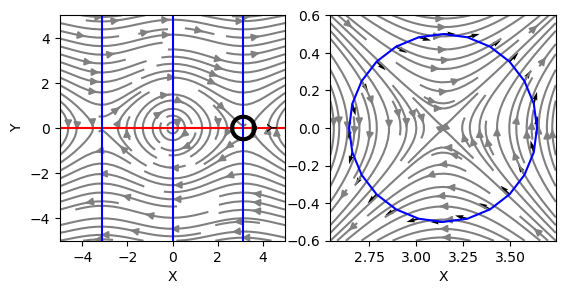

In [21]:
def pendulum(t,x,l=1,g=9.8):
    return np.array([x[1],-np.sin(x[0])])


r0=[np.pi,0]  # the coordinates for the centre of the circle
rr=  0.5   # the radius of the circle

fig, ax = plt.subplots(1, 2)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_aspect('equal')

ax[0]=plot_flow(ax[0],pendulum,xrange=[-5,5],yrange=[-5,5],nullclines=True)
ax[0]=plot_jordan(ax[0],pendulum,r0=r0,rr=rr, vectors=False,linewidth=3,color='black')

# A zoomed image
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_aspect('equal')
xrange=[r0[0]-rr-0.1,r0[0]+rr+0.1]
yrange=[r0[1]-rr-0.1,r0[1]+rr+0.1]
ax[1]=plot_flow(ax[1],pendulum,xrange=xrange,yrange=yrange,nullclines=False)

# Lets plot a Jordan curve, a circle. 
ax[1]=plot_jordan(ax[1],pendulum,r0=r0, rr=rr, vectors=True)

ax[1].set_xlim(xrange[0],xrange[1])
ax[1].set_ylim(yrange[0],yrange[1])

index = winding_number(pendulum, r0, rr)
print(f"r0: {r0}, rr: {rr}")
print(f"The index of the Jordan curve is: {index}")

### Example 1
$$
\begin{array}{rl}
\dot{x}=F(x,y)=&2x^2-1\\
\dot{y}=G(x,y)=&2xy
\end{array}
$$

In [95]:
def ex1(t,xy):
    x,y= xy
    return [2*x**2-1,2*x*y]

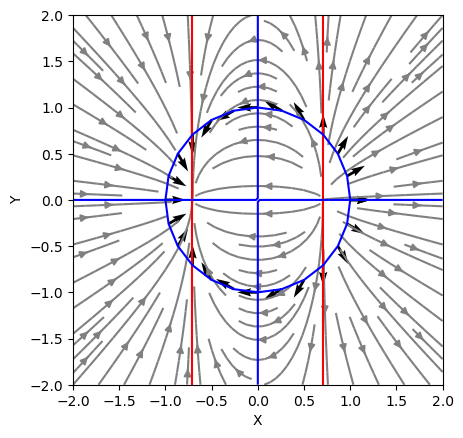

In [123]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

ax=pp.plot_flow(ax,ex1,xrange=[-2,2],yrange=[-2,2],nullclines=True)
ax=plot_jordan(ax,ex1,r0=[0,0], rr=1., vectors=True)

### Example 2
Let's look at the different critical points. Look at the following system: 
$$
\begin{array}{rl}
\dot{x}=& y \\
\dot{y}=&\beta x + 2\alpha y
\end{array}
$$

We have the following eigenvalues:
$$
\lambda_{\pm}=\alpha \pm \sqrt{\alpha^2+\beta}
$$

Cases: 
- $\alpha=0: \lambda_{\pm}=\pm \sqrt{\beta}$
-  Saddle point if $\beta >0$
-  Center if $\beta <0$
- $\alpha$ > 0: 

Use this to look at the index of the different critical points. 

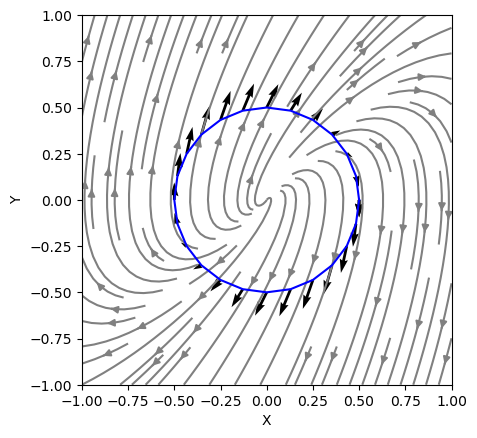

In [30]:
def ex2(t,xy):
    # alpha > 0 
    alpha=1
    beta=-1.5
    x,y=xy
    dx=y
    dy=beta*x+2*alpha*y
    return [dx,dy]
ig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

ax=plot_flow(ax,ex2,xrange=[-1,1],yrange=[-1,1],nullclines=False)
ax=plot_jordan(ax,ex2,r0=[0,0], rr=0.5, vectors=True)